<a href="https://colab.research.google.com/github/kdkim2000/JAkorea/blob/main/9__pytorch____dqn___.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch로 DQN CartPole 에이전트 구현하기

## 필요한 라이브러리 설치

In [ ]:
%%bash
# Install additional packages for visualization
sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
pip install pyvirtualdisplay > /dev/null 2>&1
pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [ ]:
import gym
import sys
import random
import numpy as np
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display

In [ ]:
# Render an episode and save as a GIF file
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
# Configuration parameters for the whole setup
seed = 42
env = gym.make("CartPole-v1")  # Create the environment
env.seed(seed)

[42]

In [ ]:
state = env.reset()

screen = env.render(mode='rgb_array')
im = Image.fromarray(screen)
images = [im]

for i in range(1000):
  action = env.action_space.sample()
  state, reward, done, info  = env.step(action) # take a random action

  # Render screen every 10 steps
  if i % 10 == 0:
    screen = env.render(mode='rgb_array')
    images.append(Image.fromarray(screen))
env.close()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
# Save GIF image
image_file = 'cartpole-v0-random.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

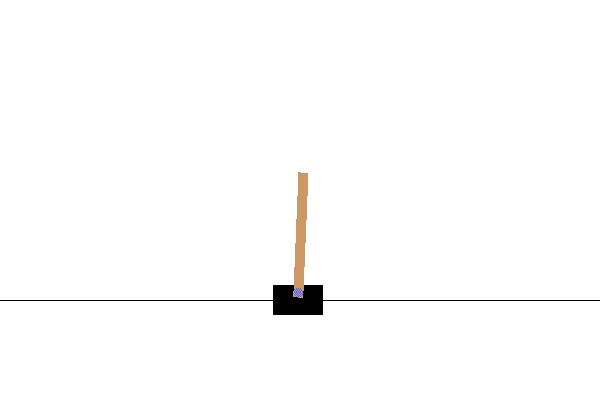

In [ ]:
from IPython.display import Image as disImage
disImage(open(image_file,'rb').read())

In [ ]:
EPISODES = 300
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# 카트폴 예제에서의 DQN 에이전트
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False

        # 상태와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size

        # DQN 하이퍼파라미터
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000

        # 리플레이 메모리, 최대 크기 2000
        self.memory = deque(maxlen=2000)

        # 모델과 타깃 모델 생성
        self.model = self.build_model()
        self.target_model = self.build_model()

        # 타깃 모델 초기화
        self.update_target_model()

    # 상태가 입력, 큐함수가 출력인 인공신경망 생성
    def build_model(self):
        model = nn.Sequential(
          nn.Linear(self.state_size, 24,),
          nn.ReLU(),
          nn.Linear(24, 24),
          nn.ReLU(),
          nn.Linear(24, self.action_size)
        )
        return model

    # 타깃 모델을 모델의 가중치로 업데이트
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        self.model.eval()
        state = torch.Tensor(state).to(device)

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model(state).detach().cpu().numpy()
            return np.argmax(q_value[0])

    # 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # 정책신경망을 업데이트 하기 위한 오류함수와 훈련함수의 생성
    def optimizer(self, state, target):
        self.model.train()
        optimizer = torch.optim.Adam(self.model.parameters(),
                                     lr=self.learning_rate)
        loss_func = nn.MSELoss()

        # 손실함수 계산
        predict = self.model(state)
        loss = loss_func(predict, target)

        # 손실에 대한 가중치의 경사도를 계산합니다
        optimizer.zero_grad()
        loss.backward()
        # 모델의 가중치를 갱신합니다
        optimizer.step()

    # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.zeros((self.batch_size, self.state_size))       # (64, 4)
        next_states = np.zeros((self.batch_size, self.state_size))  # (64, 4)
        actions, rewards, dones = [], [], []

        for i in range(self.batch_size):
            states[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])

        self.model.eval()
        self.target_model.eval()

        states = torch.Tensor(states).to(device)
        next_states = torch.Tensor(next_states).to(device)

        # 현재 상태에 대한 모델의 큐함수
        # 다음 상태에 대한 타깃 모델의 큐함수
        target = self.model(states).detach().cpu().numpy()
        target_val = self.target_model(next_states).detach().cpu().numpy()

        # 벨만 최적 방정식을 이용한 업데이트 타깃
        for i in range(self.batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * (
                    np.amax(target_val[i]))

        target = torch.Tensor(target).to(device)

        self.optimizer(states, target)

In [ ]:
# CartPole-v1 환경, 최대 타임스텝 수가 500
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# DQN 에이전트 생성
agent = DQNAgent(state_size, action_size)

scores, episodes = [], []

In [ ]:
flag = False

In [ ]:
agent.model = agent.model.to(device)
agent.target_model = agent.model.to(device)

In [ ]:
for e in range(EPISODES):

    if flag:
        break

    done = False
    score = 0
    # env 초기화
    state = env.reset()
    state = np.reshape(state, [1, state_size])

    while not done:
        if agent.render:
            env.render()

        # 현재 상태로 행동을 선택
        action = agent.get_action(state)
        # 선택한 행동으로 환경에서 한 타임스텝 진행
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])

        # 리플레이 메모리에 샘플 <s, a, r, s'> 저장
        agent.append_sample(state, action, reward, next_state, done)
        # 매 타임스텝마다 학습
        if len(agent.memory) >= agent.train_start:
            agent.train_model()

        score += reward
        state = next_state

        if done:
            # 각 에피소드마다 타깃 모델을 모델의 가중치로 업데이트
            agent.update_target_model()

            # 에피소드마다 학습 결과 출력
            scores.append(score)
            episodes.append(e)
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon)

            if score > 300:  # Condition to consider the task solved
                print("Solved at episode {}!".format(e))
                torch.save(agent.model.state_dict(), "cartpole_dqn.pt")
                flag = True
                break

episode: 0   score: 42.0   memory length: 42   epsilon: 1.0
episode: 1   score: 9.0   memory length: 51   epsilon: 1.0
episode: 2   score: 10.0   memory length: 61   epsilon: 1.0
episode: 3   score: 30.0   memory length: 91   epsilon: 1.0
episode: 4   score: 22.0   memory length: 113   epsilon: 1.0
episode: 5   score: 19.0   memory length: 132   epsilon: 1.0
episode: 6   score: 28.0   memory length: 160   epsilon: 1.0
episode: 7   score: 16.0   memory length: 176   epsilon: 1.0
episode: 8   score: 23.0   memory length: 199   epsilon: 1.0
episode: 9   score: 22.0   memory length: 221   epsilon: 1.0
episode: 10   score: 29.0   memory length: 250   epsilon: 1.0
episode: 11   score: 26.0   memory length: 276   epsilon: 1.0
episode: 12   score: 21.0   memory length: 297   epsilon: 1.0
episode: 13   score: 14.0   memory length: 311   epsilon: 1.0
episode: 14   score: 11.0   memory length: 322   epsilon: 1.0
episode: 15   score: 13.0   memory length: 335   epsilon: 1.0
episode: 16   score: 18

In [ ]:
def render_episode(env, model, max_steps):
  state = env.reset()

  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)
  images = [im]

  for i in range(1, max_steps + 1):
    # state.shpa = (4,) => (1, 4)
    state = np.expand_dims(state, axis=0)
    state = torch.from_numpy(state).type(torch.float32).to(device)
    # (1, 2)
    model.eval()
    Qs = model(state)[0].detach().cpu().numpy()
    action = np.argmax(Qs)

    state, _, done, _ = env.step(action)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))

    if done:
      break

  return images

In [ ]:
# Save GIF image
images = render_episode(env, agent.model, 1000)
image_file = 'cartpole-v1.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

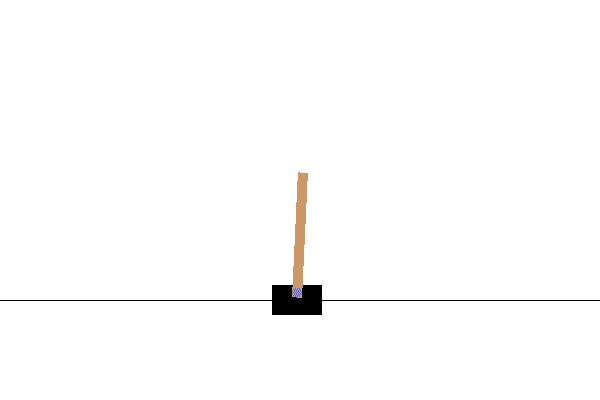

In [ ]:
disImage(open(image_file,'rb').read())